In [1]:
from anndata import AnnData
from main import integrate_data
from utils import data_preprocess,compute_ASW,compute_ARI

import scanpy as sc
import numpy as np
import time
import os
import pandas as pd

In [2]:
input_dir = 'input'
res_dir = 'result'
method_name = 'IMG'
data_name = 'pancrm'

In [3]:
start_time = time.time()
adata = sc.read_loom("../data/panc_rm.loom",sparse = False)
adata.obs['batch'] = adata.obs['batch'].astype('category')
adata.obs.batch.value_counts()

indrop        5147
smartseq2     1898
celseq2       1808
celseq         725
fluidigmc1     592
Name: batch, dtype: int64

In [4]:
adata.X = np.float32(np.int32(adata.X))
adata = data_preprocess(adata)

Establishing Adata for Next Step...


/hpcfiles/users/zcg/.conda/envs/zcg/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


PreProcess Done.


In [5]:
balance_sampling = False
batch_num = len(adata.obs.batch.unique())

In [6]:
# Whether to use batch balance sampling strategy
if balance_sampling:
    total_num = len(adata)
    per_num = int(total_num/batch_num)

    X = adata.X
    y = adata.obs.batch.tolist()

    from collections import Counter
    print(Counter(y))

    over_sample = {}
    under_sample = {}
    dict_y = Counter(y)
    for key in dict_y.keys():
        if dict_y[key] >= per_num * 1.1:
            under_sample[key] = int(per_num * 1.1)
        elif dict_y[key] <= per_num * 0.9:
            over_sample[key] = int(per_num * 0.9)

    from imblearn.over_sampling import SMOTE
    smo = SMOTE(sampling_strategy=over_sample,random_state=42)
    X_smo, y_smo = smo.fit_resample(X, y)
    print(Counter(y_smo))

    from imblearn.under_sampling import RandomUnderSampler
    cc = RandomUnderSampler(sampling_strategy=under_sample,random_state=0)
    X_resampled, y_resampled = cc.fit_resample(X_smo, y_smo)
    print(Counter(y_resampled))
    import pandas as pd
    obs = pd.DataFrame()
    obs['batch'] = y_resampled
    ppd_adata = AnnData(X_resampled,obs=obs)
else:
    ppd_adata = adata

In [7]:
sc.tl.pca(ppd_adata,n_comps=256)

In [8]:
out= integrate_data(ppd_adata, adata, batch_key='batch', n_epochs=100, mnn_times=5, len_weight=5, self_nbs=10, other_nbs=1, batch_size=1024, n_critic=100,batch_num=batch_num,balance_sampling=balance_sampling,overlap=False,under_sample=False,under_sample_num=50000)

Number of samples per batch: 2034
Times: 0
indrop<——>smartseq2


/hpcfiles/users/zcg/.conda/envs/zcg/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


indrop<——>celseq2
indrop<——>celseq
indrop<——>fluidigmc1
smartseq2<——>celseq2
smartseq2<——>celseq
smartseq2<——>fluidigmc1
celseq2<——>celseq
celseq2<——>fluidigmc1
celseq<——>fluidigmc1
Times: 1
indrop<——>smartseq2
indrop<——>celseq2
indrop<——>celseq
indrop<——>fluidigmc1
smartseq2<——>celseq2
smartseq2<——>celseq
smartseq2<——>fluidigmc1
celseq2<——>celseq
celseq2<——>fluidigmc1
celseq<——>fluidigmc1
Times: 2
indrop<——>smartseq2
indrop<——>celseq2
indrop<——>celseq
indrop<——>fluidigmc1
smartseq2<——>celseq2
smartseq2<——>celseq
smartseq2<——>fluidigmc1
celseq2<——>celseq
celseq2<——>fluidigmc1
celseq<——>fluidigmc1
Times: 3
indrop<——>smartseq2
indrop<——>celseq2
indrop<——>celseq
indrop<——>fluidigmc1
smartseq2<——>celseq2
smartseq2<——>celseq
smartseq2<——>fluidigmc1
celseq2<——>celseq
celseq2<——>fluidigmc1
celseq<——>fluidigmc1
Times: 4
indrop<——>smartseq2
indrop<——>celseq2
indrop<——>celseq
indrop<——>fluidigmc1
smartseq2<——>celseq2
smartseq2<——>celseq
smartseq2<——>fluidigmc1
celseq2<——>celseq
celseq2<——>fluidi

In [9]:
end_time = time.time()
print("耗时为: "+str(end_time-start_time))

耗时为: 141.36280179023743


In [10]:
out = AnnData(out,adata.obs)

In [11]:
sc.pp.neighbors(out)
sc.tl.umap(out)

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'ClusterName' as categorical
... storing 'celltype' as categorical


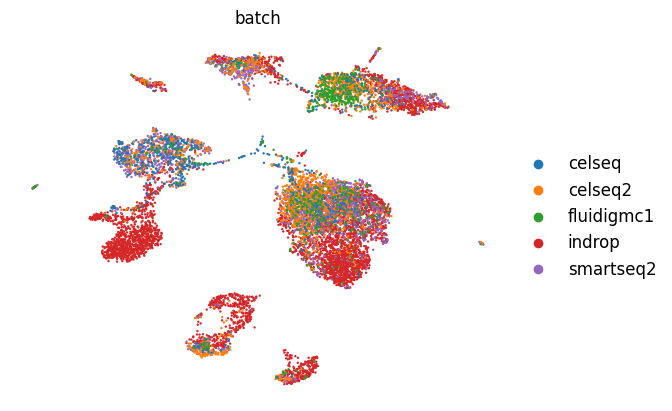

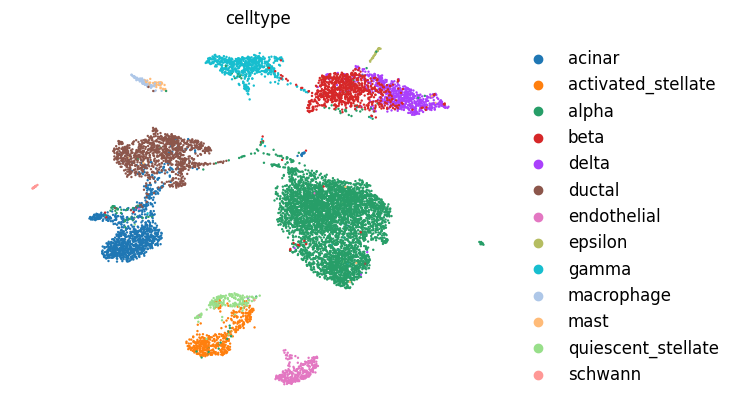

In [12]:
sc.pl.umap(out,color=['batch'],legend_fontsize=12,frameon=False,save='_'+method_name+'_'+data_name+'_batch.png')
sc.pl.umap(out,color=['celltype'],legend_fontsize=12,frameon=False,save='_'+method_name+'_'+data_name+'_celltype.png')

In [13]:
out = out[out.obs.celltype != 'acinar']
out = out[out.obs.celltype != 'delta']
out = out[out.obs.celltype != 'beta']
out = out[out.obs.celltype != 'ductal']

/hpcfiles/users/zcg/.conda/envs/zcg/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [14]:
arr = out.obsm['X_pca']
batch_label = out.obs['batch'].tolist()
cell_label = out.obs['celltype'].tolist()
asw_batch_score, asw_celltype_score = compute_ASW(arr, batch_label, cell_label)
print("ASW score：")
print(asw_batch_score,asw_celltype_score)

print("ARI score：")
batch_ARI, cell_ARI = compute_ARI(out)
print(batch_ARI, cell_ARI)

ASW score：
-0.10003015 0.44604564
ARI score：
-0.029944240208902084 0.5525015761965784


In [15]:
matrix_path = os.path.join(res_dir,method_name+'_'+data_name+'_matrix.csv')
meta_path = os.path.join(res_dir,method_name+'_'+data_name+'_meta.csv')
lisi_path = os.path.join(res_dir,method_name+'_'+data_name+'_lisi.csv')

np.savetxt(matrix_path, out.obsm['X_pca'], delimiter=',')
data = {'batch':out.obs.batch.tolist(), 'celltype':out.obs.celltype.tolist()}
df = pd.DataFrame(data)
df.to_csv(meta_path,index=False)

process_args = "~/.conda/envs/zcg/bin/Rscript LISI.R "+matrix_path+" "+meta_path+" "+lisi_path
print(os.popen(process_args).read())

[1] "batch mean LISI: "
[1] 2.173166
[1] "celltype mean LISI: "
[1] 1.045787

